# Scaffold Evolution Analysis

This notebook analyzes the effectiveness of scaffold evolution in improving crossword solving performance.
We examine how "evolutions" (variations) of scaffolds resulted in higher scores over multiple generations.

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [15]:
# Load the data
SCORES_FILE = '../experiments/keep_crosswords_20250711_195402/scoring/all_valid_scores.json'
with open(SCORES_FILE, 'r') as f:
    data = json.load(f)

print(f"Loaded data for {len(data)} scaffolds")
print(f"Sample scaffolds: {list(data.keys())[:10]}")

Loaded data for 110 scaffolds
Sample scaffolds: ['5-1-2-0', '1-6', '5-1-1', '5-1-2-1', '5-1-1-0', '5-1-2', '5-1-1-4', '5-1-2-0-0-0', '5-1-2-0-0', '5-1-2-1-1']


In [16]:
# Data processing functions
def parse_scaffold_id(scaffold_id):
    """Parse scaffold ID to extract generation depth and lineage info"""
    parts = scaffold_id.split('-')
    root = parts[0]
    generation = len(parts) - 1
    return root, generation

def get_parent_id(scaffold_id):
    """Get parent scaffold ID"""
    parts = scaffold_id.split('-')
    if len(parts) == 1:
        return None  # No parent for initial scaffolds
    return '-'.join(parts[:-1])

def get_all_ancestors(scaffold_id):
    """Get all ancestor scaffold IDs in order from root to immediate parent"""
    parts = scaffold_id.split('-')
    ancestors = []
    for i in range(1, len(parts)):
        ancestors.append('-'.join(parts[:i]))
    return ancestors

# Create a comprehensive dataframe
scaffold_data = []
for scaffold_id, scaffold_info in data.items():
    root, generation = parse_scaffold_id(scaffold_id)
    parent_id = get_parent_id(scaffold_id)
    
    scaffold_data.append({
        'scaffold_id': scaffold_id,
        'root': root,
        'generation': generation,
        'parent_id': parent_id,
        'mean_score': scaffold_info['mean_score'],
        'scores': scaffold_info['scores'],
        'score_std': np.std(scaffold_info['scores']),
        'num_runs': len(scaffold_info['scores'])
    })

df = pd.DataFrame(scaffold_data)
print(f"Processed {len(df)} scaffolds")
print(f"Generation depths: {sorted(df['generation'].unique())}")
print(f"Root scaffolds: {sorted([int(x) for x in df['root'].unique()])}")

Processed 110 scaffolds
Generation depths: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Root scaffolds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


## 1. Evolution Tree with Score Heatmap

This visualization shows the full evolution tree with nodes colored by mean score. The size of nodes represents the number of descendants (how much the algorithm explored that branch).

In [17]:
# Create network graph for evolution tree
G = nx.DiGraph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['scaffold_id'], 
               mean_score=row['mean_score'],
               generation=row['generation'],
               root=row['root'])

# Add edges (parent-child relationships)
for _, row in df.iterrows():
    if row['parent_id'] is not None and row['parent_id'] in data:
        G.add_edge(row['parent_id'], row['scaffold_id'])

# Calculate number of descendants for each node
descendants = {}
for node in G.nodes():
    descendants[node] = len(list(nx.descendants(G, node)))

print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Created graph with 110 nodes and 90 edges


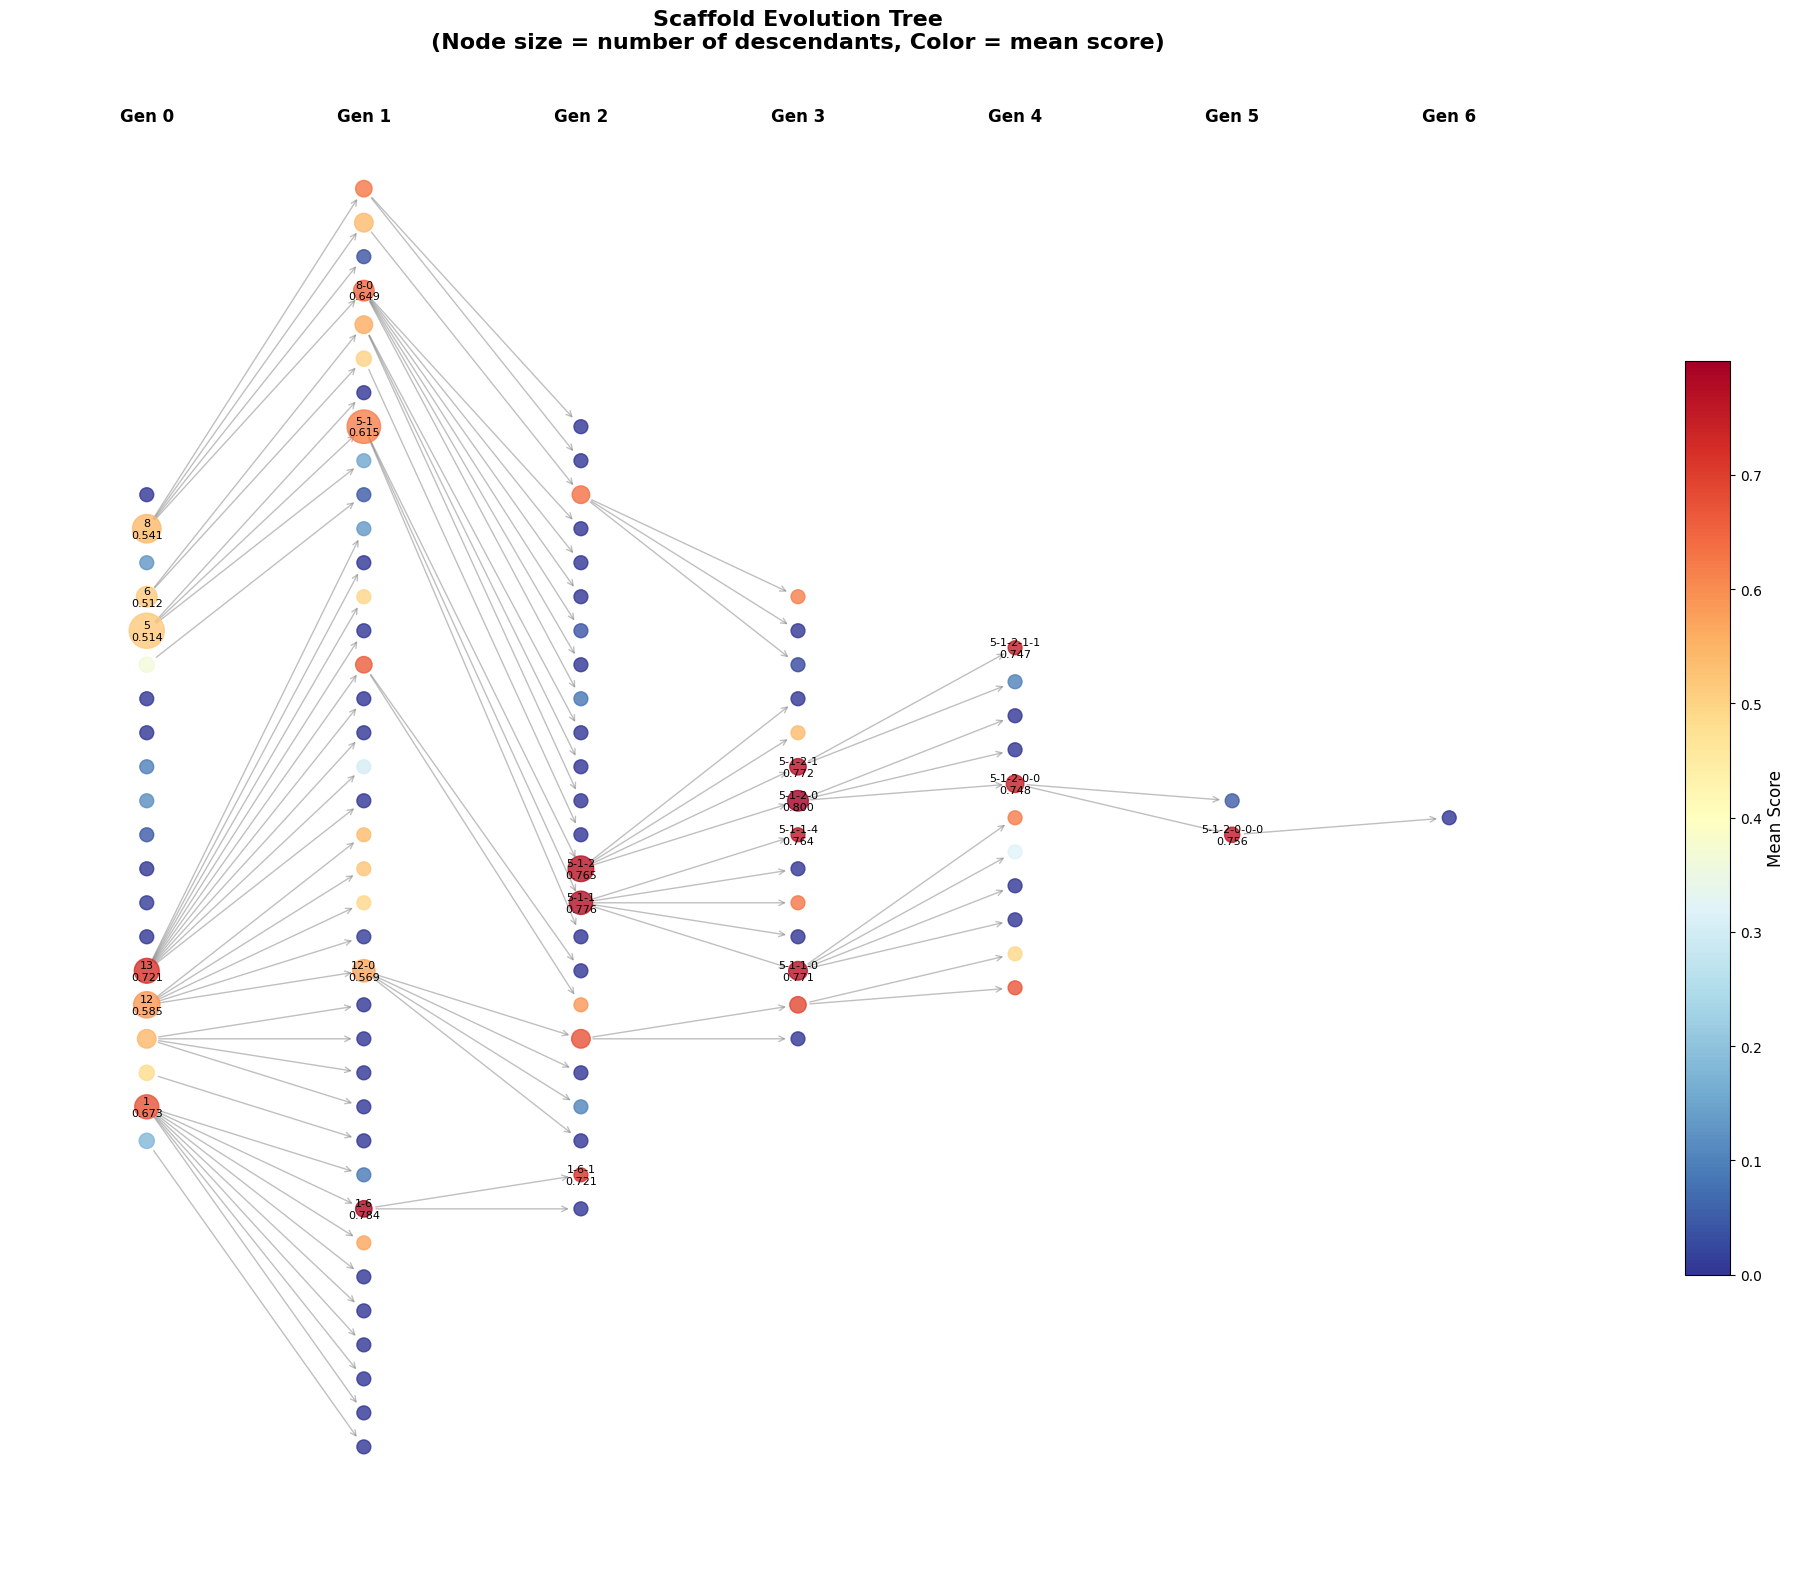


Top 10 scaffolds by score:
scaffold_id  mean_score  generation root
    5-1-2-0    0.799588           3    5
        1-6    0.783902           1    1
      5-1-1    0.775816           2    5
    5-1-2-1    0.771906           3    5
    5-1-1-0    0.771415           3    5
      5-1-2    0.765455           2    5
    5-1-1-4    0.764318           3    5
5-1-2-0-0-0    0.755864           5    5
  5-1-2-0-0    0.748491           4    5
  5-1-2-1-1    0.746541           4    5


In [18]:
# Plot evolution tree
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

# Create layout - separate by generation
pos = {}
generation_counts = df.groupby('generation').size().to_dict()
generation_positions = {}

for gen in sorted(df['generation'].unique()):
    gen_nodes = df[df['generation'] == gen]['scaffold_id'].tolist()
    gen_count = len(gen_nodes)
    
    # Sort by root and then by scaffold_id for consistent positioning
    gen_nodes_df = df[df['generation'] == gen].sort_values(['root', 'scaffold_id'])
    
    for i, (_, row) in enumerate(gen_nodes_df.iterrows()):
        x = gen * 3  # Horizontal spacing by generation
        y = (i - gen_count/2) * 0.5  # Vertical spacing
        pos[row['scaffold_id']] = (x, y)

# Get node attributes
node_scores = [G.nodes[node]['mean_score'] for node in G.nodes()]
node_sizes = [max(50, descendants[node] * 20 + 100) for node in G.nodes()]

# Create colormap
vmin, vmax = min(node_scores), max(node_scores)
cmap = plt.cm.RdYlBu_r

# Draw the graph
nx.draw_networkx_nodes(G, pos, 
                       node_color=node_scores,
                       node_size=node_sizes,
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       alpha=0.8)

nx.draw_networkx_edges(G, pos, 
                       edge_color='gray',
                       alpha=0.5,
                       arrows=True,
                       arrowsize=10,
                       arrowstyle='->')

# Add labels for high-scoring or highly-explored nodes
important_nodes = []
for node in G.nodes():
    score = G.nodes[node]['mean_score']
    desc_count = descendants[node]
    if score > 0.7 or desc_count > 5:
        important_nodes.append(node)

labels = {node: f"{node}\n{G.nodes[node]['mean_score']:.3f}" for node in important_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Mean Score', fontsize=12)

# Formatting
ax.set_title('Scaffold Evolution Tree\n(Node size = number of descendants, Color = mean score)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Generation', fontsize=12)
ax.axis('off')

# Add generation labels
for gen in sorted(df['generation'].unique()):
    ax.text(gen * 3, max([pos[node][1] for node in pos]) + 1, 
            f'Gen {gen}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTop 10 scaffolds by score:")
top_scaffolds = df.nlargest(10, 'mean_score')[['scaffold_id', 'mean_score', 'generation', 'root']]
print(top_scaffolds.to_string(index=False))

## 2. Score Distribution by Generation Depth (Violin Plot + Swarm)

This shows how scores are distributed at each generation level, with each point colored by its root ancestor to show which initial scaffolds led to successful lineages.

In [19]:
# Prepare data for violin plot using mean scores only
plot_data = []
for _, row in df.iterrows():
    plot_data.append({
        'scaffold_id': row['scaffold_id'],
        'generation': row['generation'],
        'root': row['root'],
        'score': row['mean_score'],
        'mean_score': row['mean_score']
    })

plot_df = pd.DataFrame(plot_data)
print(f"Created plot dataframe with {len(plot_df)} scaffolds using mean scores")

# Create color mapping for roots - focus on the most successful roots
root_performance = df.groupby('root')['mean_score'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
print("\nRoot scaffold performance:")
print(root_performance.head(10))

# Get distinct colors for top performing roots
top_roots = root_performance.head(10).index.tolist()
colors = plt.cm.Set3(np.linspace(0, 1, len(top_roots)))
root_colors = {root: colors[i] for i, root in enumerate(top_roots)}
# Gray for all other roots
for root in df['root'].unique():
    if root not in root_colors:
        root_colors[root] = 'lightgray'

Created plot dataframe with 110 scaffolds using mean scores

Root scaffold performance:
          mean       max  count
root                           
12    0.381644  0.688735     14
5     0.372661  0.799588     28
1     0.257743  0.783902     11
10    0.243389  0.486777      2
13    0.241712  0.721408     12
6     0.224828  0.561468      7
8     0.223068  0.648730     17
4     0.204759  0.364634      2
7     0.124972  0.124972      1
18    0.117344  0.117344      1


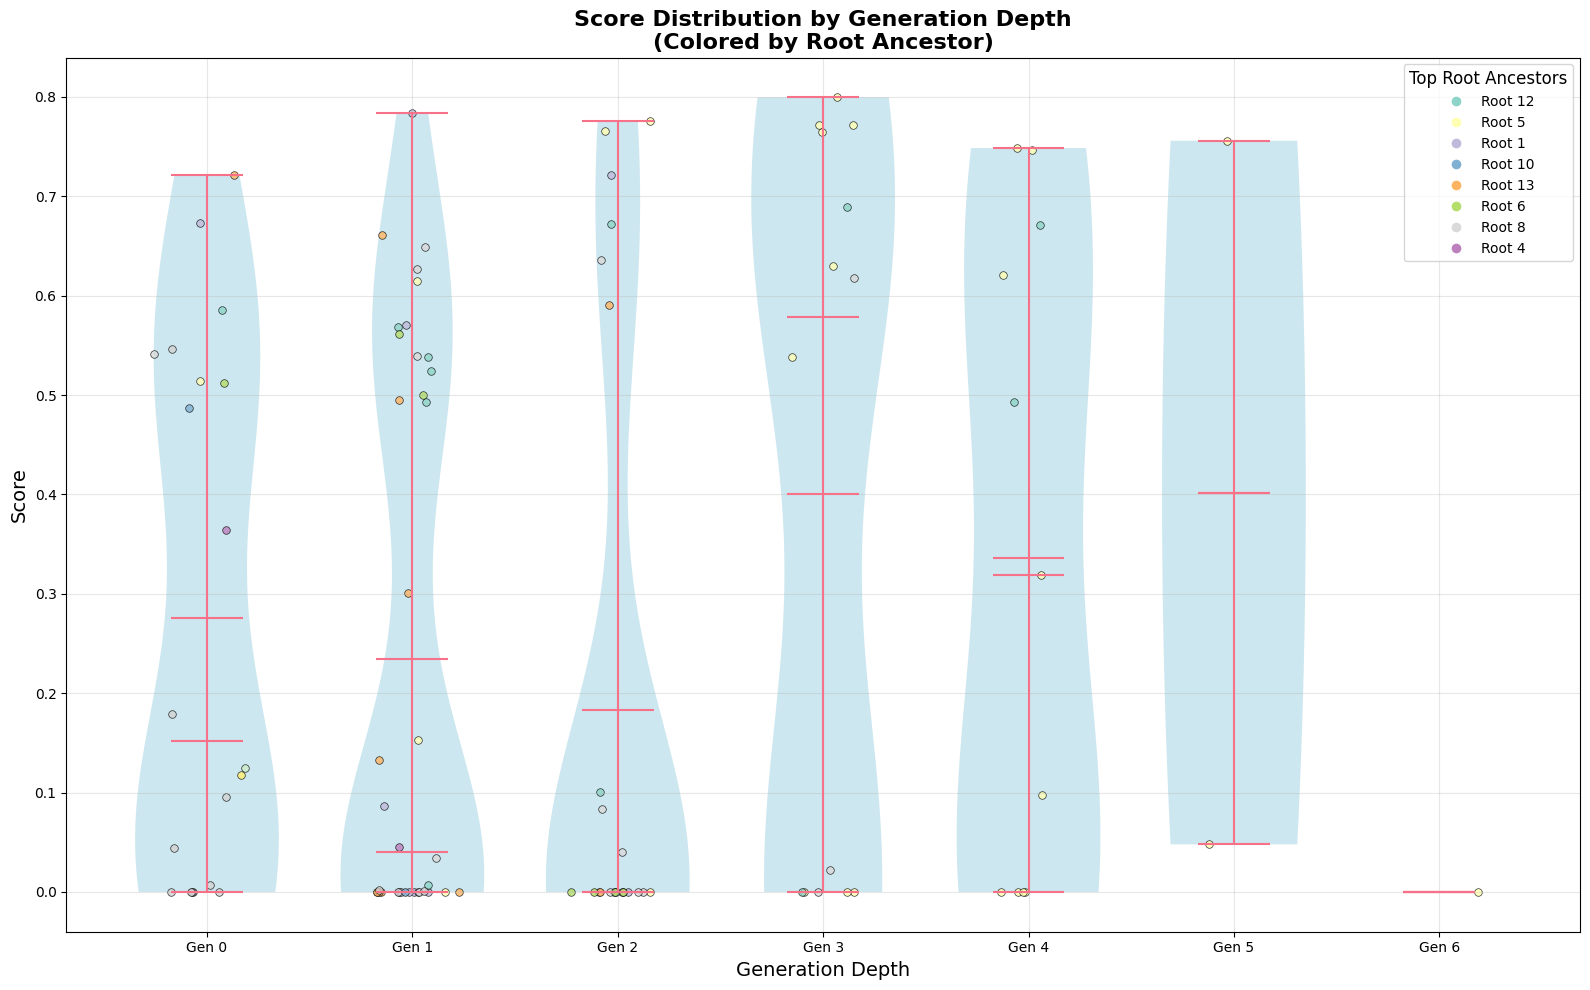


Score statistics by generation:
            count      mean       std       min       max
generation                                               
0              20  0.275641  0.267209  0.000000  0.721408
1              38  0.233960  0.278245  0.000000  0.783902
2              24  0.182711  0.304278  0.000000  0.775816
3              14  0.400332  0.363108  0.000000  0.799588
4              11  0.336016  0.326364  0.000000  0.748491
5               2  0.401866  0.500630  0.047867  0.755864
6               1  0.000000       NaN  0.000000  0.000000


In [20]:
# Create the violin plot with swarm overlay
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Violin plot
parts = ax.violinplot([plot_df[plot_df['generation'] == gen]['score'].values 
                      for gen in sorted(plot_df['generation'].unique())],
                     positions=sorted(plot_df['generation'].unique()),
                     widths=0.7, showmeans=True, showmedians=True)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.6)

# Add swarm plot overlay colored by root
for gen in sorted(plot_df['generation'].unique()):
    gen_data = plot_df[plot_df['generation'] == gen]
    
    # Use stripplot for better control
    for root in gen_data['root'].unique():
        root_data = gen_data[gen_data['root'] == root]
        
        # Add small jitter to x-position
        x_jitter = np.random.normal(gen, 0.1, len(root_data))
        
        ax.scatter(x_jitter, root_data['score'], 
                  color=root_colors[root], 
                  alpha=0.8, 
                  s=30, 
                  label=f'Root {root}' if gen == 0 else '',
                  edgecolors='black', 
                  linewidth=0.5)

# Formatting
ax.set_xlabel('Generation Depth', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Score Distribution by Generation Depth\n(Colored by Root Ancestor)', 
             fontsize=16, fontweight='bold')

# Set x-axis ticks
generations = sorted(plot_df['generation'].unique())
ax.set_xticks(generations)
ax.set_xticklabels([f'Gen {g}' for g in generations])

# Add grid
ax.grid(True, alpha=0.3)

# Create custom legend for top roots only
legend_elements = []
for root in top_roots[:8]:  # Show top 8 roots in legend
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=root_colors[root], 
                                     markersize=8, label=f'Root {root}'))

ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
          title='Top Root Ancestors', title_fontsize=12)

plt.tight_layout()
plt.show()

# Print statistics by generation
print("\nScore statistics by generation:")
generation_stats = plot_df.groupby('generation')['score'].agg(['count', 'mean', 'std', 'min', 'max'])
print(generation_stats)

## 3. Parent-Child Score Improvement Analysis

This scatter plot shows whether evolution generally improves performance. Points above the diagonal line represent improvements over the parent scaffold.

In [21]:
# Prepare parent-child comparison data
parent_child_data = []
for _, row in df.iterrows():
    if row['parent_id'] is not None and row['parent_id'] in data:
        parent_score = data[row['parent_id']]['mean_score']
        child_score = row['mean_score']
        improvement = child_score - parent_score
        
        parent_child_data.append({
            'parent_id': row['parent_id'],
            'child_id': row['scaffold_id'],
            'parent_score': parent_score,
            'child_score': child_score,
            'improvement': improvement,
            'generation': row['generation'],
            'root': row['root'],
            'parent_generation': row['generation'] - 1
        })

pc_df = pd.DataFrame(parent_child_data)
print(f"Found {len(pc_df)} parent-child pairs")
print(f"Improvements: {(pc_df['improvement'] > 0).sum()} positive, {(pc_df['improvement'] < 0).sum()} negative")
print(f"Average improvement: {pc_df['improvement'].mean():.4f}")

Found 90 parent-child pairs
Improvements: 13 positive, 77 negative
Average improvement: -0.3900


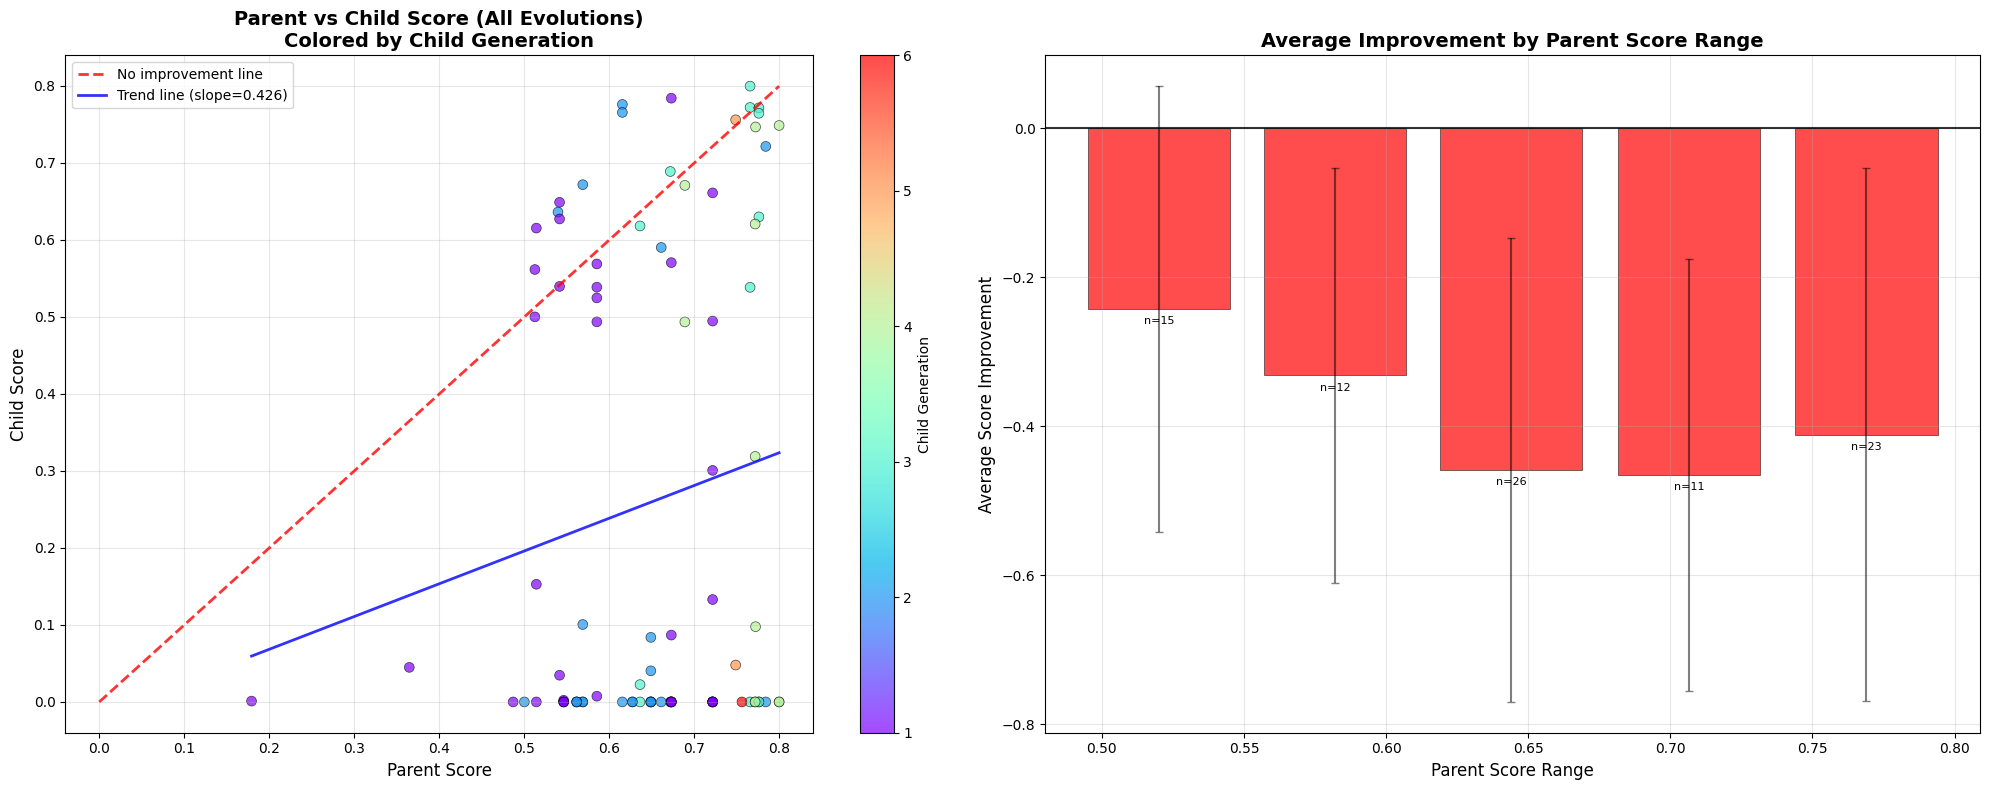


Improvement analysis:
Total evolutions: 90
Positive improvements: 13 (14.4%)
Negative improvements: 77 (85.6%)
No change: 0
Average improvement: -0.3900 ± 0.3143
Median improvement: -0.5451

Improvement by generation:
            count      mean       std
generation                           
1              38 -0.364687  0.300876
2              24 -0.437317  0.304887
3              14 -0.327683  0.350089
4              11 -0.428139  0.342992
5               2 -0.346625  0.500630
6               1 -0.755864       NaN


In [22]:
# Create parent-child improvement scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: All parent-child pairs
scatter = ax1.scatter(pc_df['parent_score'], pc_df['child_score'], 
                     c=pc_df['generation'], 
                     cmap='rainbow', 
                     alpha=0.7, 
                     s=50,
                     edgecolors='black',
                     linewidth=0.5)

# Add diagonal line (no improvement)
min_score = min(pc_df['parent_score'].min(), pc_df['child_score'].min())
max_score = max(pc_df['parent_score'].max(), pc_df['child_score'].max())
ax1.plot([min_score, max_score], [min_score, max_score], 
         'r--', alpha=0.8, linewidth=2, label='No improvement line')

# Add trend line
z = np.polyfit(pc_df['parent_score'], pc_df['child_score'], 1)
p = np.poly1d(z)
ax1.plot(pc_df['parent_score'].sort_values(), p(pc_df['parent_score'].sort_values()), 
         'b-', alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.3f})')

ax1.set_xlabel('Parent Score', fontsize=12)
ax1.set_ylabel('Child Score', fontsize=12)
ax1.set_title('Parent vs Child Score (All Evolutions)\nColored by Child Generation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add colorbar for generation
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Child Generation', fontsize=10)

# Right plot: Improvement by parent score range
# Bin by parent score ranges
pc_df['parent_score_bin'] = pd.cut(pc_df['parent_score'], bins=10)
improvement_by_bin = pc_df.groupby('parent_score_bin')['improvement'].agg(['mean', 'count', 'std'])
improvement_by_bin = improvement_by_bin.dropna()

bin_centers = [interval.mid for interval in improvement_by_bin.index]
mean_improvements = improvement_by_bin['mean'].values
counts = improvement_by_bin['count'].values
stds = improvement_by_bin['std'].fillna(0).values

# Create bar plot
bars = ax2.bar(bin_centers, mean_improvements, 
               width=0.05, alpha=0.7, 
               color=['green' if x > 0 else 'red' for x in mean_improvements],
               edgecolor='black', linewidth=0.5)

# Add error bars
ax2.errorbar(bin_centers, mean_improvements, yerr=stds, 
             fmt='none', color='black', alpha=0.5, capsize=3)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., 
             height + (0.01 if height >= 0 else -0.01),
             f'n={count}', ha='center', va='bottom' if height >= 0 else 'top',
             fontsize=8)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8)
ax2.set_xlabel('Parent Score Range', fontsize=12)
ax2.set_ylabel('Average Score Improvement', fontsize=12)
ax2.set_title('Average Improvement by Parent Score Range', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed improvement statistics
print("\nImprovement analysis:")
print(f"Total evolutions: {len(pc_df)}")
print(f"Positive improvements: {(pc_df['improvement'] > 0).sum()} ({(pc_df['improvement'] > 0).mean()*100:.1f}%)")
print(f"Negative improvements: {(pc_df['improvement'] < 0).sum()} ({(pc_df['improvement'] < 0).mean()*100:.1f}%)")
print(f"No change: {(pc_df['improvement'] == 0).sum()}")
print(f"Average improvement: {pc_df['improvement'].mean():.4f} ± {pc_df['improvement'].std():.4f}")
print(f"Median improvement: {pc_df['improvement'].median():.4f}")

print("\nImprovement by generation:")
gen_improvements = pc_df.groupby('generation')['improvement'].agg(['count', 'mean', 'std'])
print(gen_improvements)

## 4. Score Consistency vs Performance Analysis

This scatter plot shows the relationship between mean performance and score consistency (standard deviation). Points in the bottom-right represent the ideal: high performance with low variability.

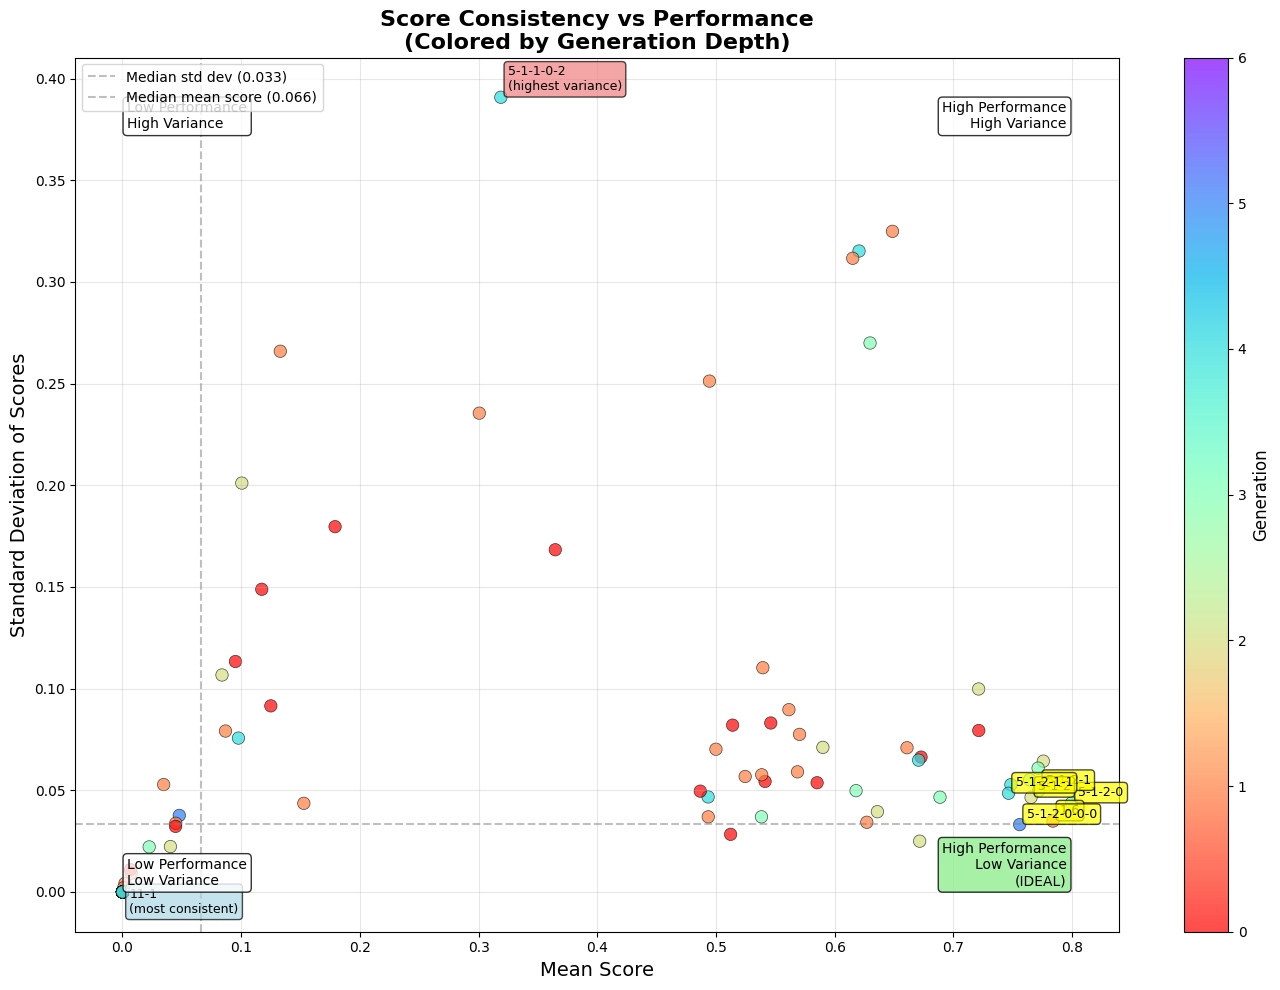

SCORE CONSISTENCY ANALYSIS:
Most consistent scaffold: 11-1 (std: 0.0000)
Most variable scaffold: 5-1-1-0-2 (std: 0.3908)

Top 5 most consistent scaffolds:
scaffold_id  mean_score  score_std  generation
       11-1         0.0        0.0           1
    5-1-2-3         0.0        0.0           3
    5-1-1-3         0.0        0.0           3
        1-4         0.0        0.0           1
       11-0         0.0        0.0           1

Top 5 performers with low variance (std < 0.1):
scaffold_id  mean_score  score_std  generation
    5-1-2-0    0.799588   0.043730           3
        1-6    0.783902   0.034878           1
      5-1-1    0.775816   0.064333           2
    5-1-2-1    0.771906   0.049864           3
    5-1-1-0    0.771415   0.060892           3

Correlation between mean score and std dev: 0.4115

Consistency by generation:
                mean    median  count
generation                           
0           0.062092  0.054049     20
1           0.060851  0.034038     38


In [23]:
# Score Consistency vs Performance Analysis
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Create the scatter plot
scatter = ax.scatter(df['mean_score'], df['score_std'], 
                    c=df['generation'], 
                    cmap='rainbow_r',
                    s=80,
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Generation', fontsize=12)

# Identify and annotate interesting scaffolds
# Top performers (high mean, low std)
top_performers = df[(df['mean_score'] > 0.7) & (df['score_std'] < 0.05)]
# Consistent performers (very low std regardless of mean)
consistent_performers = df[df['score_std'] < 0.02]
# High variance scaffolds
high_variance = df[df['score_std'] > 0.15]

# Annotate top performers
for _, row in top_performers.iterrows():
    ax.annotate(row['scaffold_id'], 
                (row['mean_score'], row['score_std']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Annotate most consistent
if len(consistent_performers) > 0:
    most_consistent = consistent_performers.loc[consistent_performers['score_std'].idxmin()]
    ax.annotate(f"{most_consistent['scaffold_id']}\n(most consistent)", 
                (most_consistent['mean_score'], most_consistent['score_std']),
                xytext=(5, -15), textcoords='offset points',
                fontsize=9, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# Annotate highest variance
if len(high_variance) > 0:
    highest_variance = high_variance.loc[high_variance['score_std'].idxmax()]
    ax.annotate(f"{highest_variance['scaffold_id']}\n(highest variance)", 
                (highest_variance['mean_score'], highest_variance['score_std']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# Add reference lines
ax.axhline(y=df['score_std'].median(), color='gray', linestyle='--', alpha=0.5, 
           label=f'Median std dev ({df["score_std"].median():.3f})')
ax.axvline(x=df['mean_score'].median(), color='gray', linestyle='--', alpha=0.5,
           label=f'Median mean score ({df["mean_score"].median():.3f})')

# Formatting
ax.set_xlabel('Mean Score', fontsize=14)
ax.set_ylabel('Standard Deviation of Scores', fontsize=14)
ax.set_title('Score Consistency vs Performance\n(Colored by Generation Depth)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

# Add quadrant labels
ax.text(0.95, 0.95, 'High Performance\nHigh Variance', 
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax.text(0.95, 0.05, 'High Performance\nLow Variance\n(IDEAL)', 
        transform=ax.transAxes, ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))
ax.text(0.05, 0.95, 'Low Performance\nHigh Variance', 
        transform=ax.transAxes, ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax.text(0.05, 0.05, 'Low Performance\nLow Variance', 
        transform=ax.transAxes, ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print analysis
print("SCORE CONSISTENCY ANALYSIS:")
print("=" * 50)
print(f"Most consistent scaffold: {df.loc[df['score_std'].idxmin(), 'scaffold_id']} (std: {df['score_std'].min():.4f})")
print(f"Most variable scaffold: {df.loc[df['score_std'].idxmax(), 'scaffold_id']} (std: {df['score_std'].max():.4f})")
print(f"\nTop 5 most consistent scaffolds:")
most_consistent = df.nsmallest(5, 'score_std')[['scaffold_id', 'mean_score', 'score_std', 'generation']]
print(most_consistent.to_string(index=False))

print(f"\nTop 5 performers with low variance (std < 0.1):")
reliable_performers = df[df['score_std'] < 0.1].nlargest(5, 'mean_score')[['scaffold_id', 'mean_score', 'score_std', 'generation']]
if len(reliable_performers) > 0:
    print(reliable_performers.to_string(index=False))
else:
    print("No scaffolds found with std < 0.1")

print(f"\nCorrelation between mean score and std dev: {df['mean_score'].corr(df['score_std']):.4f}")

# Check if later generations are more consistent
generation_consistency = df.groupby('generation')['score_std'].agg(['mean', 'median', 'count'])
print(f"\nConsistency by generation:")
print(generation_consistency)

## Summary Statistics and Insights

Comprehensive analysis of the scaffold evolution experiment results.

In [24]:
# Summary insights
print("=" * 60)
print("SCAFFOLD EVOLUTION ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. OVERALL EVOLUTION EFFECTIVENESS:")
success_rate = (pc_df['improvement'] > 0).mean() * 100
print(f"   • Evolution success rate: {success_rate:.1f}% of evolutions improved over parent")
print(f"   • Average improvement per evolution: {pc_df['improvement'].mean():.4f}")
print(f"   • Best improvement: +{pc_df['improvement'].max():.4f}")
print(f"   • Worst regression: {pc_df['improvement'].min():.4f}")

print("\n2. EXPLORATION STATISTICS:")
print(f"   • Total scaffolds tested: {len(df)}")
print(f"   • Maximum generation depth: {df['generation'].max()}")
print(f"   • Most explored root: Root {df.groupby('root').size().idxmax()} ({df.groupby('root').size().max()} scaffolds)")

top_lineage = df[df['root'] == df.groupby('root').size().idxmax()].sort_values('mean_score', ascending=False).iloc[0]
print(f"   • Best scaffold from most explored root: {top_lineage['scaffold_id']} (score: {top_lineage['mean_score']:.4f})")

print("\n3. PERFORMANCE BY GENERATION:")
for gen in sorted(df['generation'].unique()):
    gen_df = df[df['generation'] == gen]
    print(f"   • Generation {gen}: {len(gen_df)} scaffolds, mean score {gen_df['mean_score'].mean():.4f}, best {gen_df['mean_score'].max():.4f}")

print("\n4. ROOT SCAFFOLD RANKINGS:")
root_rankings = df.groupby('root').agg({
    'mean_score': ['count', 'mean', 'max'],
    'generation': 'max'
}).round(4)
root_rankings.columns = ['Descendants', 'Avg_Score', 'Best_Score', 'Max_Gen']
root_rankings = root_rankings.sort_values('Best_Score', ascending=False)
print(root_rankings.head(10))

print("\n5. KEY INSIGHTS:")
if pc_df['improvement'].mean() > 0:
    print(f"   • Evolution is generally effective (positive average improvement)")
else:
    print(f"   • Evolution shows mixed results (negative average improvement)")

if df.groupby('generation')['mean_score'].mean().is_monotonic_increasing:
    print(f"   • Later generations consistently perform better")
else:
    print(f"   • Performance doesn't consistently improve with generation depth")

best_scaffold = df.loc[df['mean_score'].idxmax()]
print(f"   • Best overall scaffold: {best_scaffold['scaffold_id']} (score: {best_scaffold['mean_score']:.4f}, generation: {best_scaffold['generation']})")

print(f"   • Algorithm focused on root {df.groupby('root').size().idxmax()} which {'was' if df.groupby('root')['mean_score'].mean().idxmax() == df.groupby('root').size().idxmax() else 'was not'} the most promising initially")

SCAFFOLD EVOLUTION ANALYSIS SUMMARY

1. OVERALL EVOLUTION EFFECTIVENESS:
   • Evolution success rate: 14.4% of evolutions improved over parent
   • Average improvement per evolution: -0.3900
   • Best improvement: +0.1606
   • Worst regression: -0.7996

2. EXPLORATION STATISTICS:
   • Total scaffolds tested: 110
   • Maximum generation depth: 6
   • Most explored root: Root 5 (28 scaffolds)
   • Best scaffold from most explored root: 5-1-2-0 (score: 0.7996)

3. PERFORMANCE BY GENERATION:
   • Generation 0: 20 scaffolds, mean score 0.2756, best 0.7214
   • Generation 1: 38 scaffolds, mean score 0.2340, best 0.7839
   • Generation 2: 24 scaffolds, mean score 0.1827, best 0.7758
   • Generation 3: 14 scaffolds, mean score 0.4003, best 0.7996
   • Generation 4: 11 scaffolds, mean score 0.3360, best 0.7485
   • Generation 5: 2 scaffolds, mean score 0.4019, best 0.7559
   • Generation 6: 1 scaffolds, mean score 0.0000, best 0.0000

4. ROOT SCAFFOLD RANKINGS:
      Descendants  Avg_Score  Bes